In [41]:
import json
import os
os.chdir("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from glob import glob

import torch

In [19]:
from lib import train
from lib import models
from lib import metrics
from lib.utils import *

In [3]:
TRAIN = os.path.join("data", "train")
TRAIN_MSK = os.path.join("data", "train_mask")
VAL= os.path.join("data", "valid")
VAL_MSK = os.path.join("data", "valid_mask")
TEST = os.path.join("data", "test")
TEST_MSK = os.path.join("data", "test_mask")

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Использованные дополнительные библиотеки

* imgaug -- аугментации. **Не работает с numpy>=1.16.0!**
* segmentation_models_pytorch -- реализации нескольких архитектур для сегментации с предобученными базовыми моделями
* pydensecrf -- реализация Conditional Random Fields

# Данные

`notebooks/"Data Lookup.ipynb"`

Данные представляют из себя кропы цветных изображений размером 240х320. Человек на большинстве кадров один и занимает ~60% кадра. слишком темные и пересвеченные изображения практически отсутствуют, датасет явяется довольно чистым. Чаще всего кадры сбалансированны по яркости, histogram equilizationxfot часто только ухудшает качество снимка на недостаточно контрастных кадрах.

Вероятно, данные были получены из instagram или другой социальной сети. К ним иногда применялись различные визуальные фильтры.

Маски часто содержат артефакты на границах. В обучающей выборке содержится 1315 файлов, в валидационной 145 файлов. Я отложил 45 из них для итогового тестирования моделей.

# Аугментации

`notebooks/augmentations.ipynb`

Для экономии времени на данный этап, была использована библиотека, содержащая большое количество различных типов аугментаций imgaug (https://github.com/aleju/imgaug). Плюсом данной библиотеки является возможность применения аугментаций одновременно к изображению и маске.

Изначально были выбраны следующие аугментации:

* Горизонтальное отзеркаливание -- наиболее стандартная аугментация
* Афинное преобразование -- поворот до 30 градусов и сжатие растяжение до 20%
* Шум
    * Гауссовский
    * Шум типа соль-перец
    * Шум типа соль-перец по областям -- добавлен, так как на некоторых изображениях сеть не добавляет в маску объекты, которые находятся в руках модели, хотя в разметке они есть (хотя я бы сказал, что это недоработка разметки)
* Гауссово размытие
* Изменения контрастности изображения (в том числе отдельно по каналам) -- так как изображения сделаны в разных условиях, а к некоторым применялись различные цветные фильтры, данная аугментация поможет лучше подготовить к такому модель
    * Gamma Contrast
    * Sigmoid contrast
    * Linear Contrast
    * CLAHE
* Деформация изображения
    
Аугментации из списка были протестированны по отдельности на простой модели. Результаты тестирования приведены в таблице ниже. Для сравнения также приведено качество моделей без аугментаций.

In [2]:
pd.read_json("results/augmentations.json").T

f-score       iou
no_aug    0.959862  0.927140
Flip-lr   0.964886  0.935092
contrast  0.967045  0.938485
elastic   0.965203  0.935752
affine    0.967146  0.939448
noise     0.908004  0.839923
blur      0.961013  0.928530

Видно, что добавление шума существенно ухудшает качество модели. Это может быть связано с тем, что датасет сам по себе является довольно чистым.

Наибольший прирост качества дает афинное преобразование. Практически такой же прирост дает изменение контрастности.

Не такой большой прирост качества дают эластичная деформация и отражение по горизонтали.

Размытие практически не влияет на качество модели.

Исходя из этого, было принято решение в итоговой аугсентации увеличить вероятность срабатывания афинного преобразования и преобразования контрастности до 0.8,  а деформации до 0.6.

# Модели

`notebooks/models.ipynb`

Для решения задачи было выбрано несколько различных архитектур. 

* FCN -- простая модель с небольшим количеством параметров. Реализована на PyTorch. Было сделано предположение, что простая обученная с нуля модель покажет хороший результат на небольшом объеме довольно хороших данных.
* U-Net -- baseline-модель. Реализация взята с https://github.com/milesial/Pytorch-UNet, последня активания изменена с sigmoid на простые logits для совместимости с другими моделями
* U-Net cпредобученными базовыми моделями -- взято из библиотеки segmentation_models_pytorch, на основе которой также сделано обучение. Использовалась с предобученными энкодерами:
    * ResNet18 -- использовалась для всех тестов как самая быстрая
    * VGG11
    * SE-ResNeXt50
* PSPNet -- Несмотря на неподходящую задаче архитектуру, была попытка обучения модели. Использовалась реализация из segmentation_models_pytorch. В качестве backbone выбрана предобученная SE-ResNeXt50.
* FPN -- Описана в статье 2019г., является одной из актуальных архитектур. На ее основе была улучшена SOTA-модель HRNetV2. Использовалась реализация из segmentation_models_pytorch. В качестве backbone выбрана предобученная SE-ResNeXt50.
    
Краткое описание архитектур приведено в `notebooks/articles.ipynb`.

Тестовая модель была обучена на 150 эпох. Ниже приведен график качества модели на валидации. 

Во время тестирования всех моделей сравнивался показатель mIoU, так как является более сильной метрикой, чем Dice.

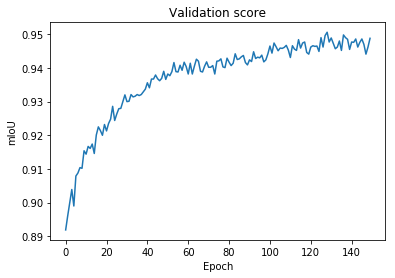

In [4]:
with open("results/full_train.txt") as f:
    lines = f.readlines()
    
scores = []
for line in lines:
    if line[:5]=="valid":
        scores.append(float(line.split()[-4][:-1]))
        
plt.plot(scores)
plt.title("Validation score")
plt.xlabel("Epoch")
plt.ylabel("mIoU");

Видно, что после 50 эпохи скорость обучения существенно падает. С учетом ограниченности времени, тестирование всех моделей проводилось в равных условиях, то есть 50 эпох, с размером батча 8 (максимальный, с которым работали все модели). Для предобученных моделей learning rate установлен на 1e-6, для остальных 1e-4. 

Линейного уменьшения learning rate при обучении не проводилось, так как модели не дообучались.

Ниже приведено итоговое качество всех моделей, обученных с указанными выше параметрами.

In [7]:
with open("results/model_logs.json", "r") as f:
    logs = json.load(f)    

In [21]:
for model_name in logs:
    print(f"{model_name:15}: {logs[model_name][0]:.4}")

resnet18_noaug : 0.9396
resnet18       : 0.9446
vgg11          : 0.9183
seresnext      : 0.9621
unet           : 0.9189
fcn            : 0.7914
psp_seresnext  : 0.8949
fpn_seresnext  : 0.9404


Видно, что лучшей моделью на является `U-net+SE-ResNeXt50`, затем `U-net+ResNet18`, далее `FPN+SE-ResNeXt50`.

Построим графики качества на валидации для всех моделей 

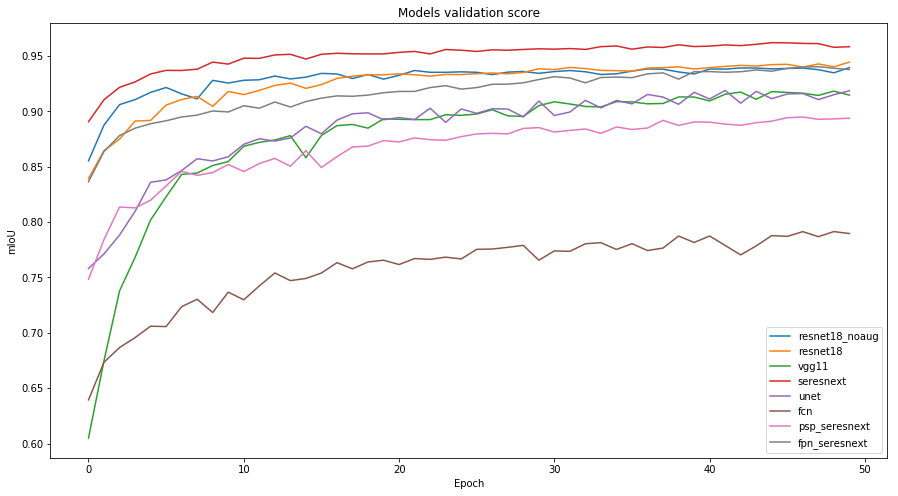

In [32]:
plt.figure(figsize=(15,8))
plt.title("Models validation score")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
for model_name in logs:
    scores = [x[1]["iou"] for x in logs[model_name][1]]
    plt.plot(scores, label=model_name)
plt.legend();

Из графиков видно, что модель `FPN+SE-ResNeXt50` явно недообученна, скорость прироста качества у данной модели максимальна, а по качеству она приближается к `U-net+SE-ResNeXt50`. При дальнейшем обучении, она скорее всего окажется лучшей моделью. 

Однако, к сожалению, на дообучение этих двух моделей времени не осталось.

# Тестирование модели

Загрузим 2 лучшие модели и оценим их качество на отложенной выборке.

In [36]:
# U-net
model = torch.load("models/unet_seresnext50.pth")
trainer = train.Trainer(model, "models/_.pth", 
                  TRAIN, TRAIN_MSK, 
                  VAL, VAL_MSK,
                  data_test = TEST,
                  masks_test = TEST_MSK,
                  device=DEVICE
                 )
results = trainer.get_test_score()

valid: 100%|██████████████████| 45/45 [00:03<00:00, 13.79it/s, bce_dice_loss - 0.09726, iou - 0.9545, f-score - 0.9763]


In [37]:
# FPN
model = torch.load("models/fpn_seresnext50.pth")
trainer = train.Trainer(model, "models/_.pth", 
                  TRAIN, TRAIN_MSK, 
                  VAL, VAL_MSK,
                  data_test = TEST,
                  masks_test = TEST_MSK,
                  device=DEVICE
                 )
results = trainer.get_test_score()

valid: 100%|███████████████████| 45/45 [00:03<00:00, 14.50it/s, bce_dice_loss - 0.1315, iou - 0.9361, f-score - 0.9661]


Применим Fully Connected CRF в качестве постпроцессинга к моделям и вычислим значение целевой метрики.

In [9]:
# U-Net
model = torch.load("models/unet_seresnext50.pth")
crf_model = models.CRFModel(model, DEVICE)

0.9751731025362201 0.9727834650012901


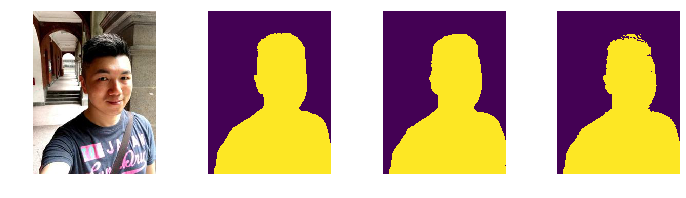

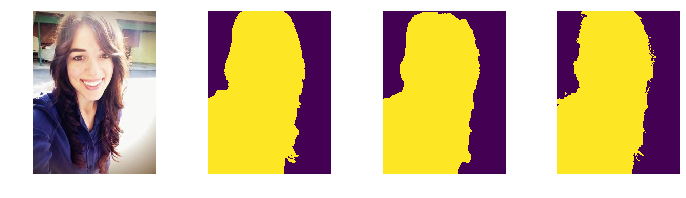

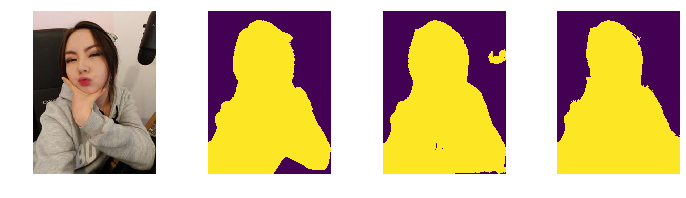

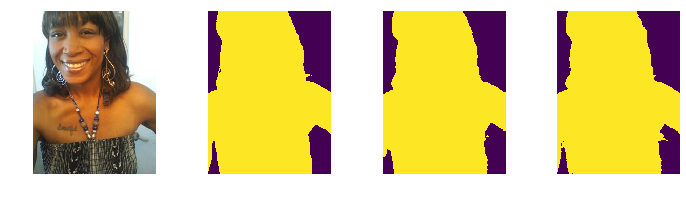

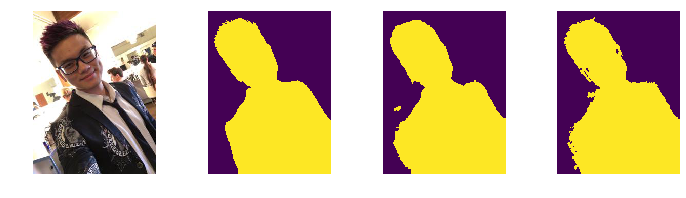

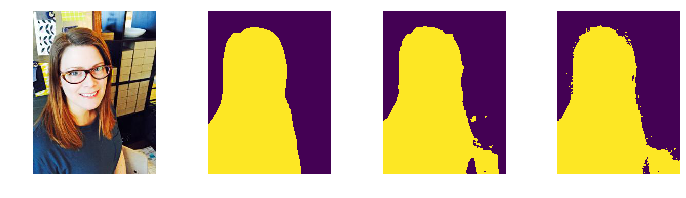

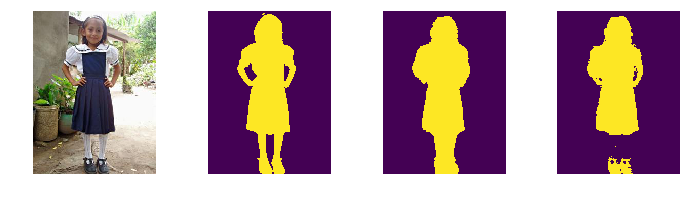

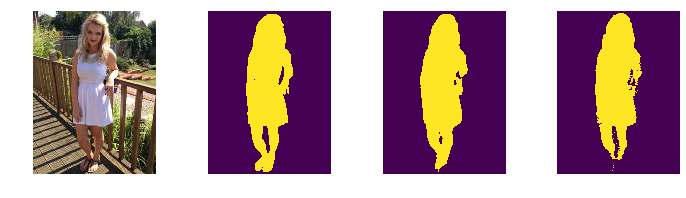

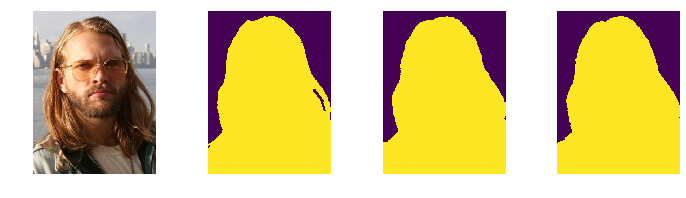

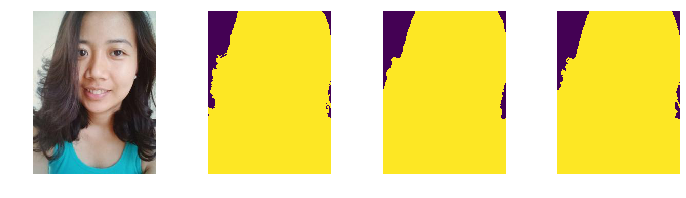

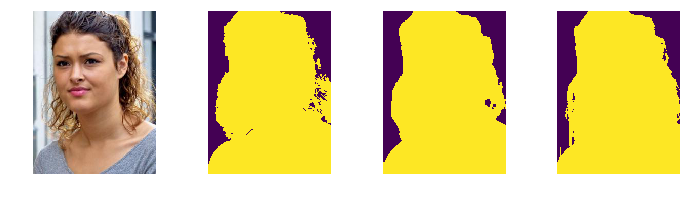

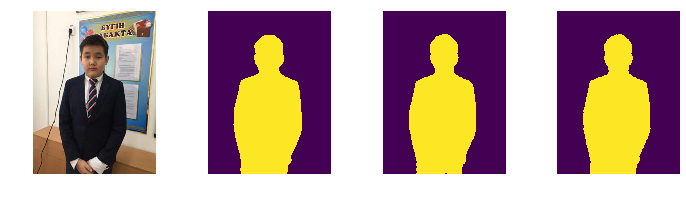

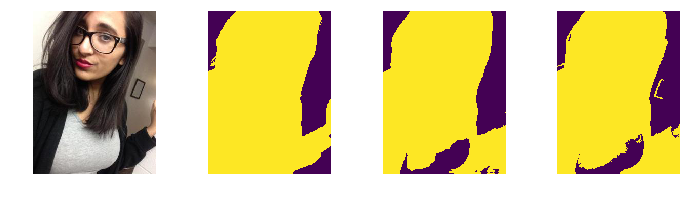

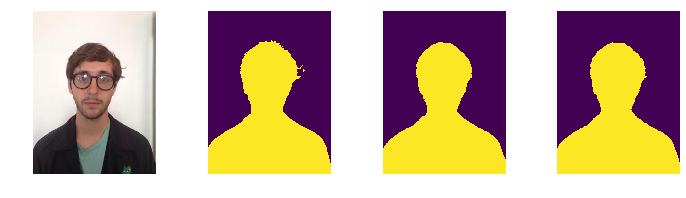

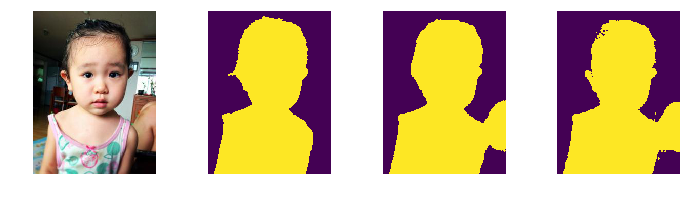

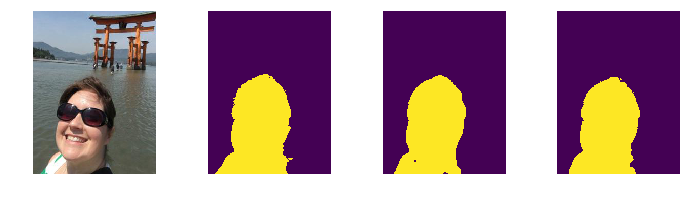

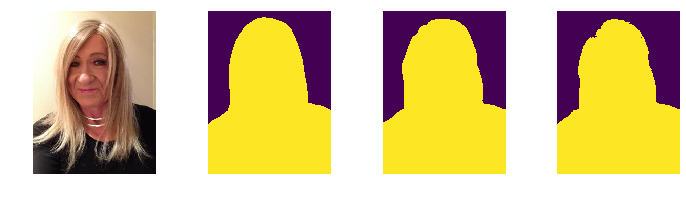

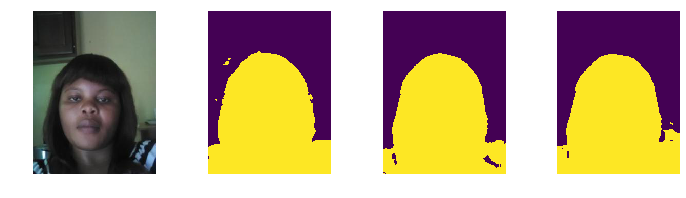

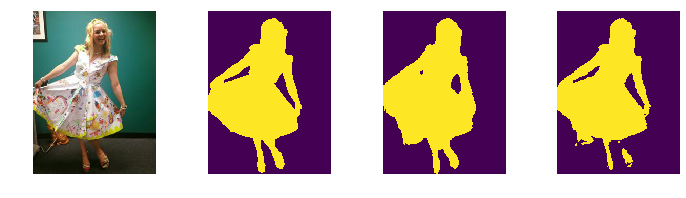

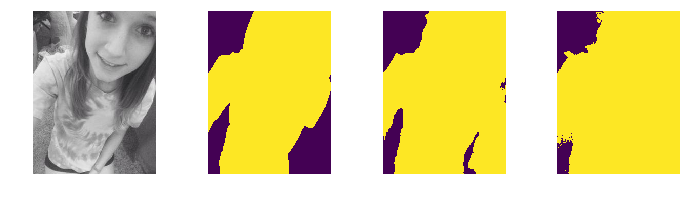

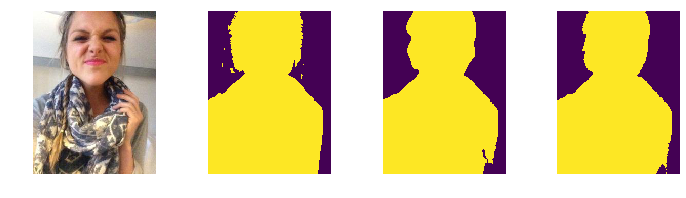

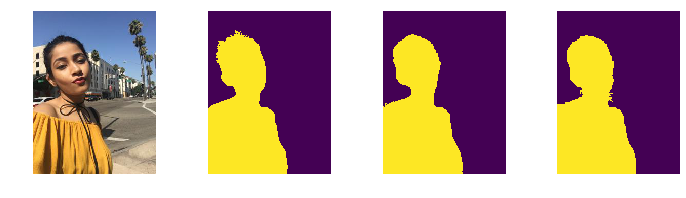

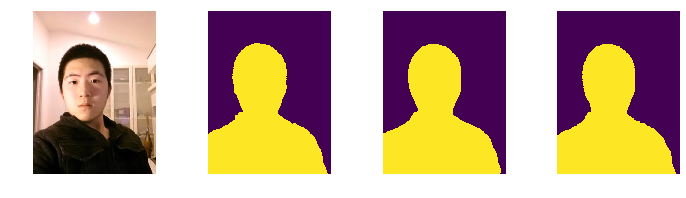

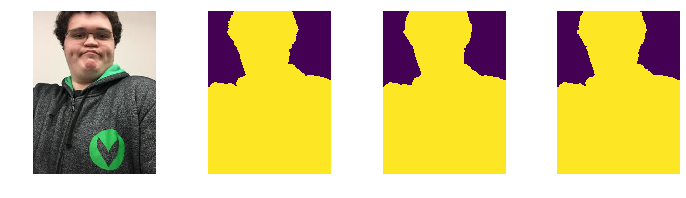

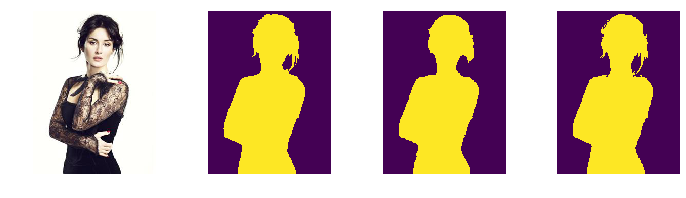

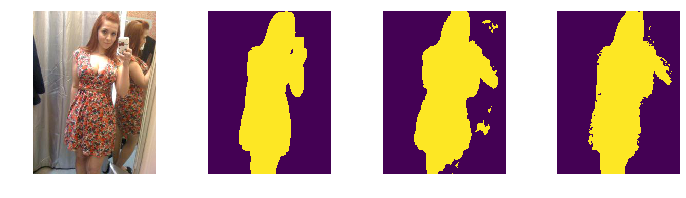

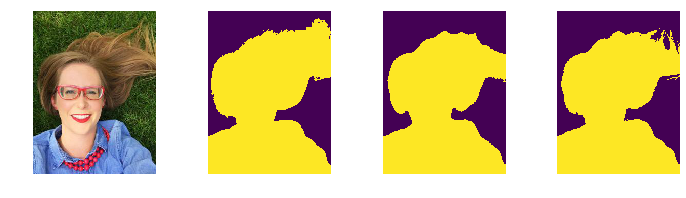

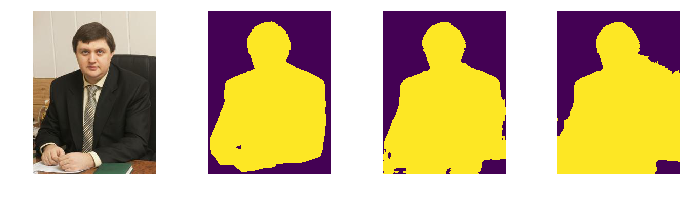

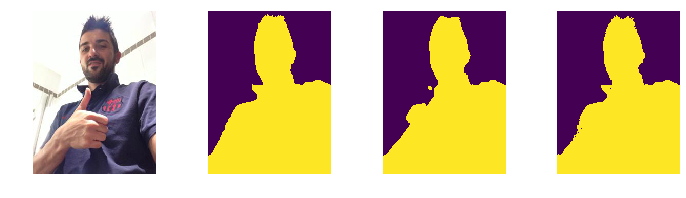

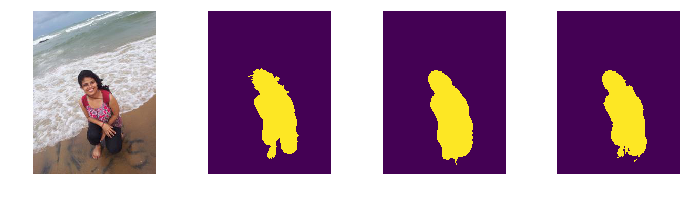

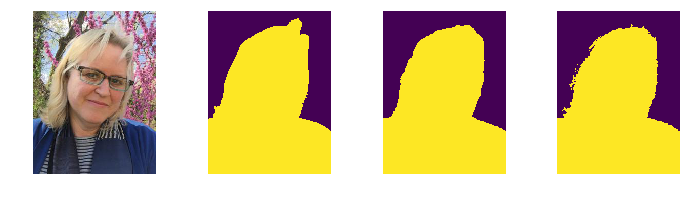

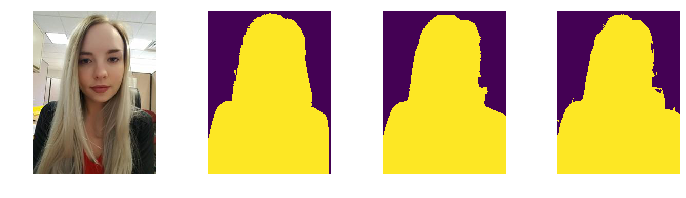

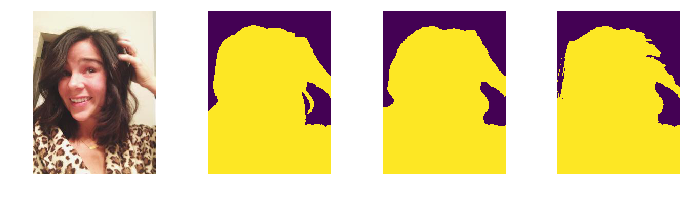

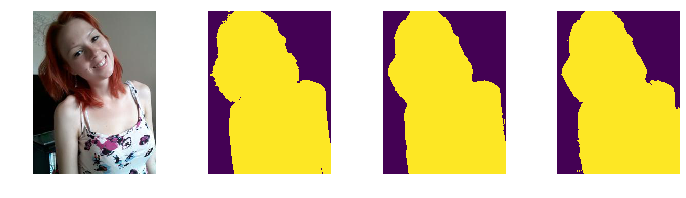

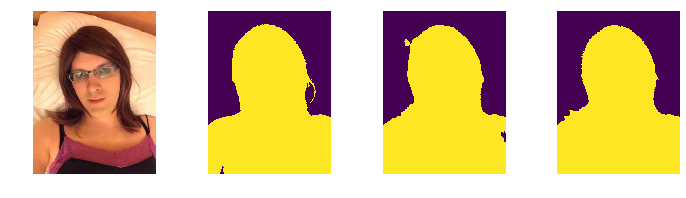

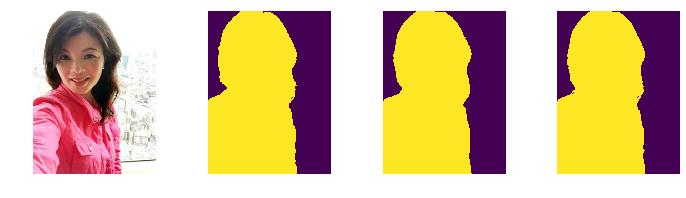

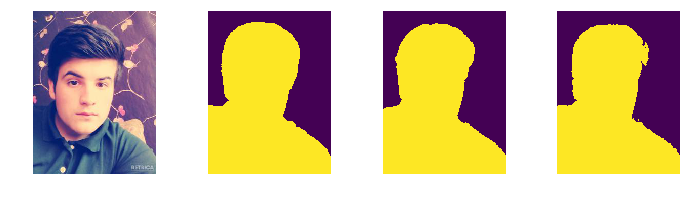

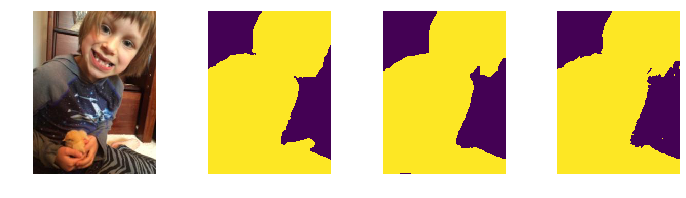

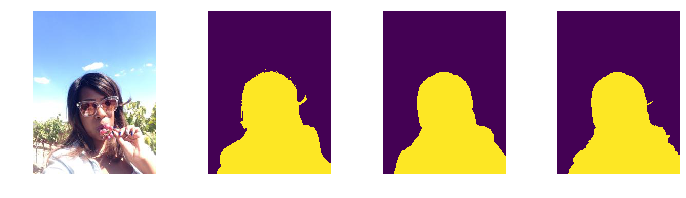

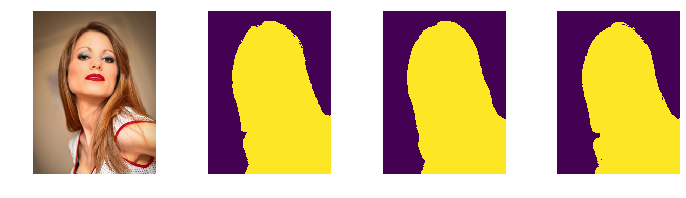

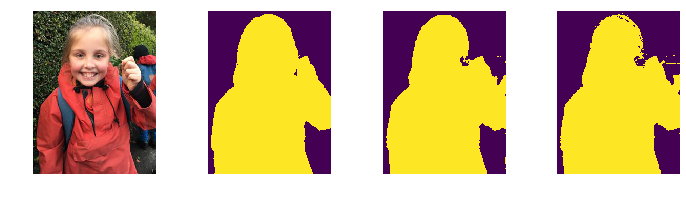

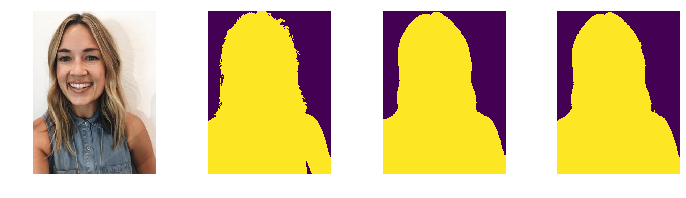

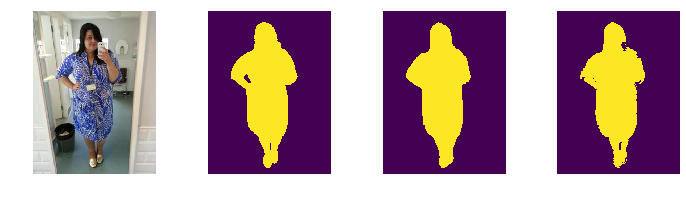

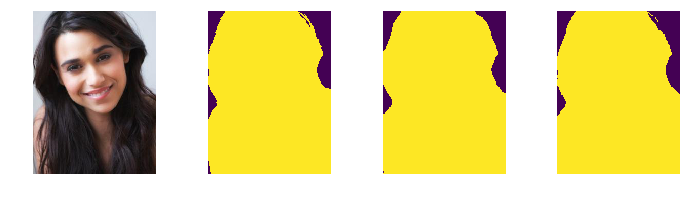

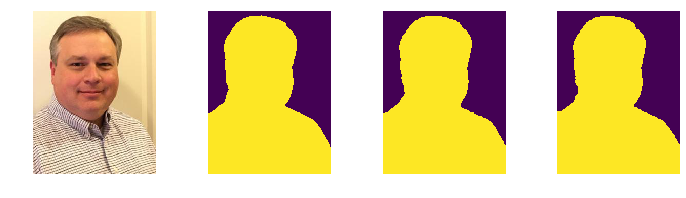

In [10]:
scores_crf = []
scores = []
for img_path, mask_path in zip(os.listdir(TEST), os.listdir(TEST_MSK)):
    img = plt.imread(os.path.join(TEST, img_path))
    img_ = cv2.resize(img, (224, 224))
    mask = plt.imread(os.path.join(TEST_MSK, mask_path))
    pred_crf = crf_model.get_mask(img_)
    pred_crf = cv2.resize(pred_crf.astype(np.uint8), mask.shape[::-1])
    pred = crf_model.get_mask(img_, no_crf=True)
    pred = cv2.resize(pred.astype(np.uint8), mask.shape[::-1])
    
    scores.append(metrics.dice(mask, pred))
    scores_crf.append(metrics.dice(mask, pred_crf))
    
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(142)
    plt.axis("off")
    plt.imshow(mask)
    plt.subplot(143)
    plt.axis("off")
    plt.imshow(pred)
    plt.subplot(144)
    plt.axis("off")
    plt.imshow(pred_crf)
    
print(np.mean(scores), np.mean(scores_crf))

In [11]:
# FPN
model = torch.load("models/fpn_seresnext50.pth")
crf_model = models.CRFModel(model, DEVICE)

0.9658454618727826 0.967032824702372


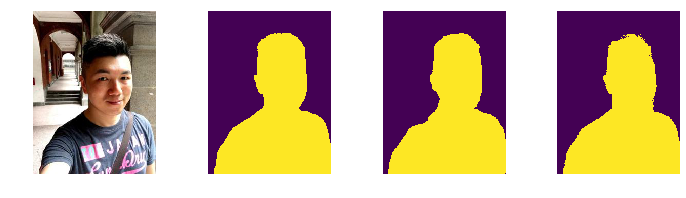

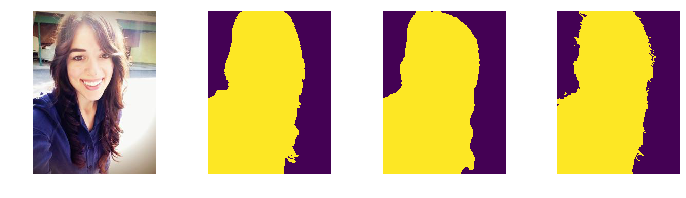

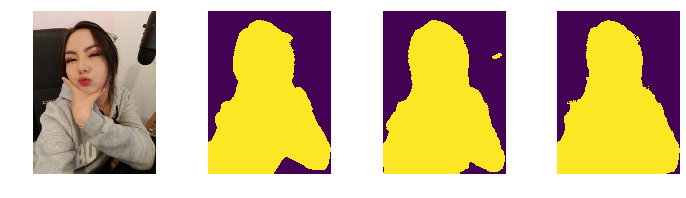

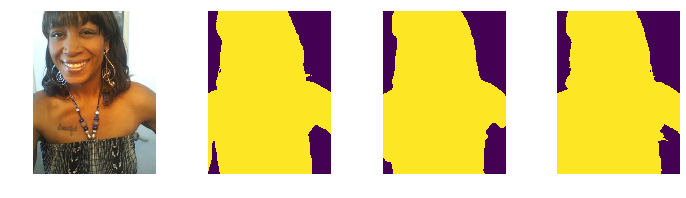

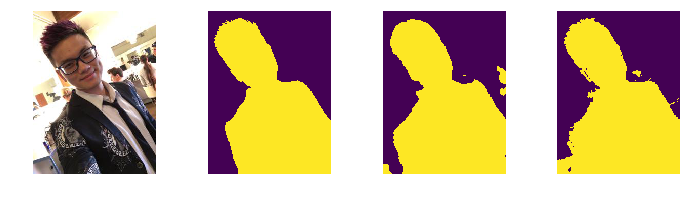

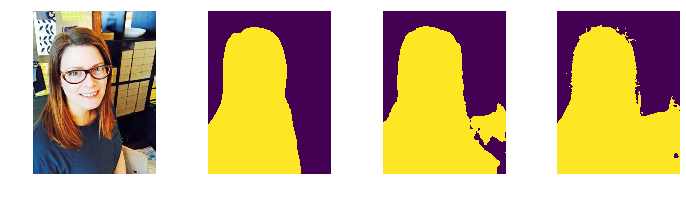

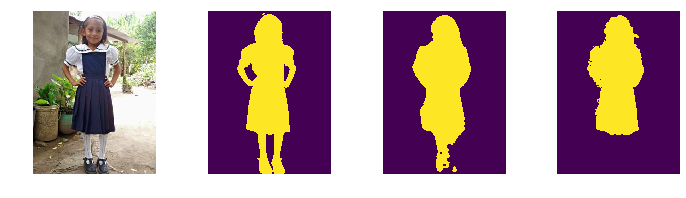

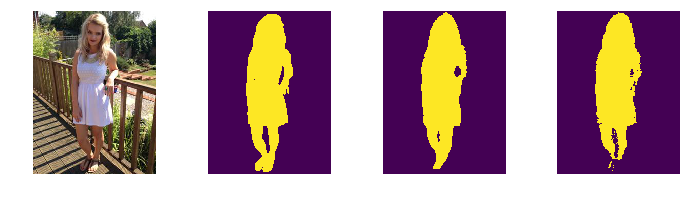

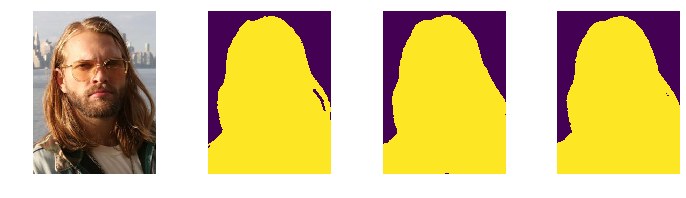

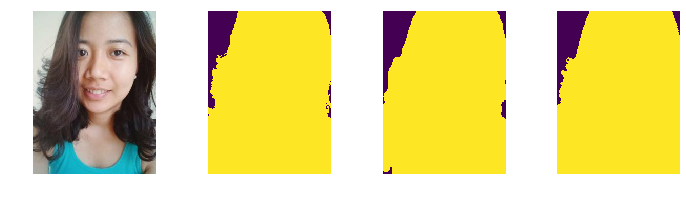

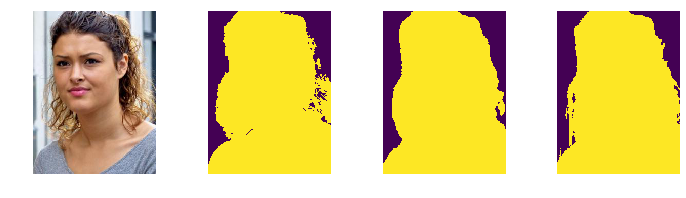

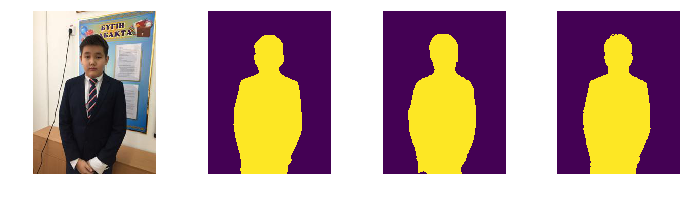

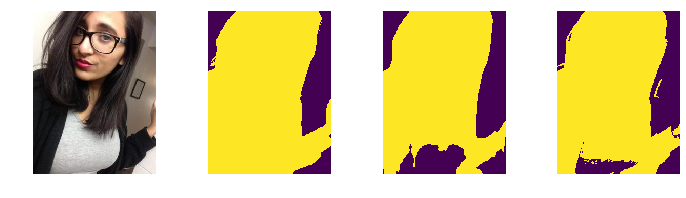

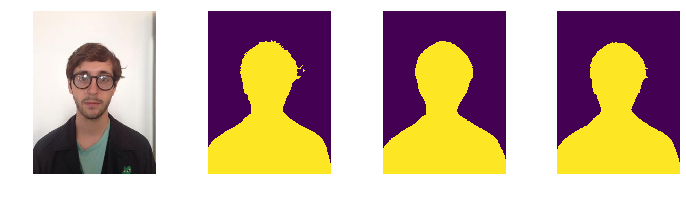

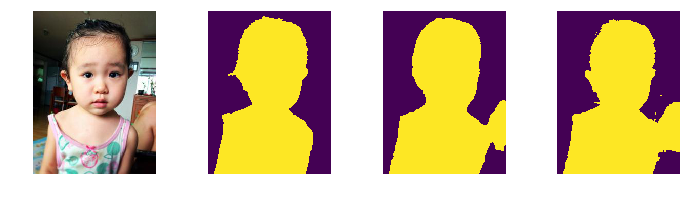

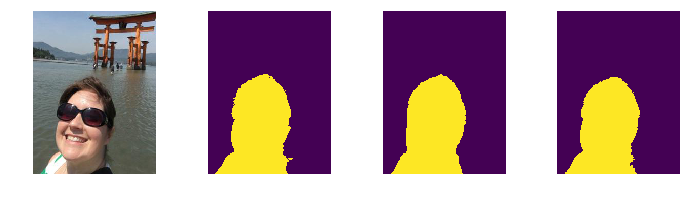

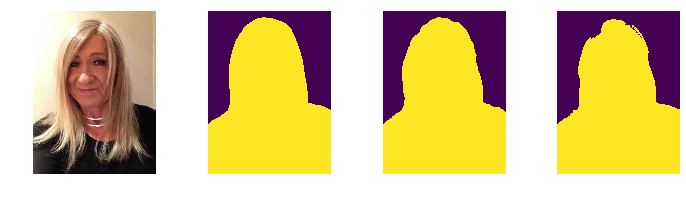

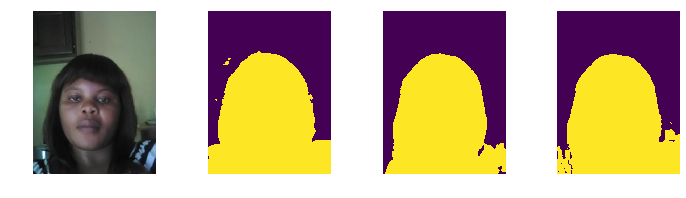

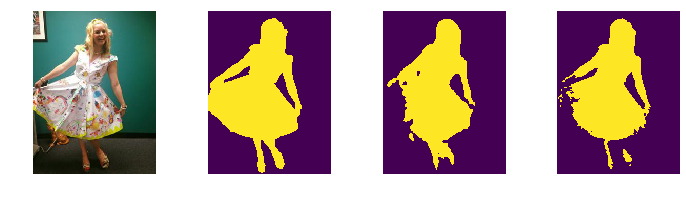

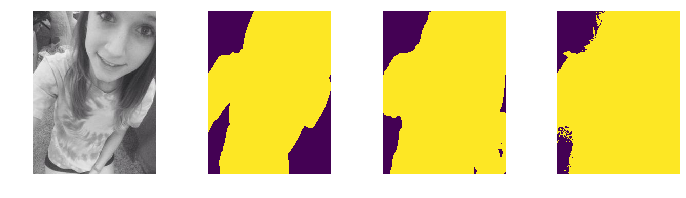

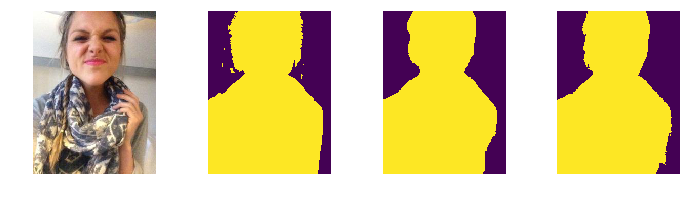

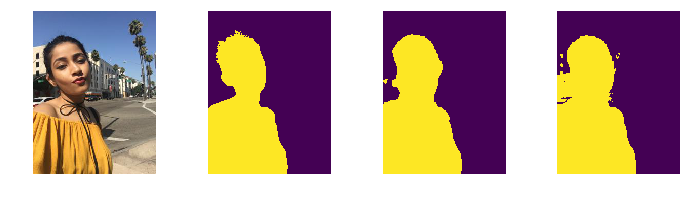

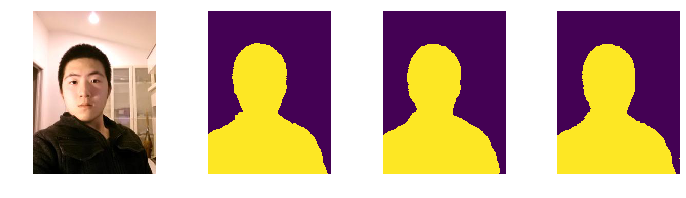

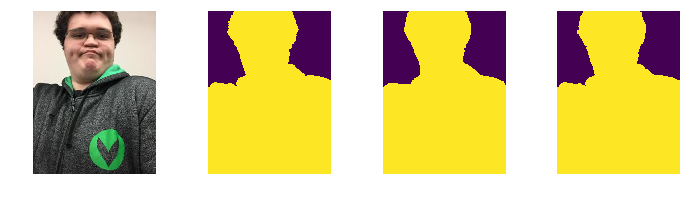

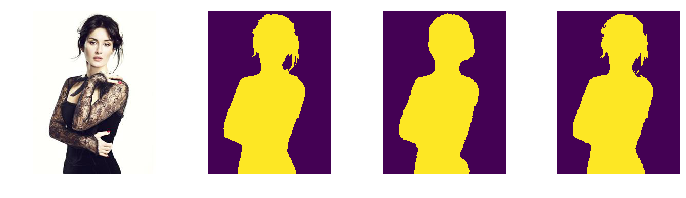

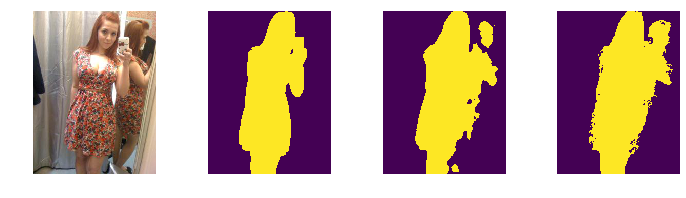

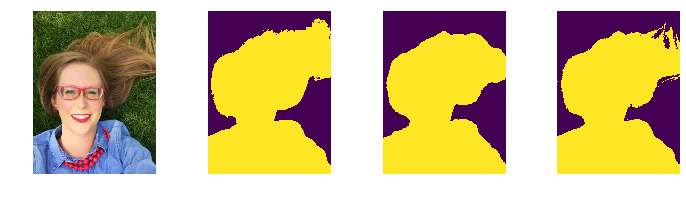

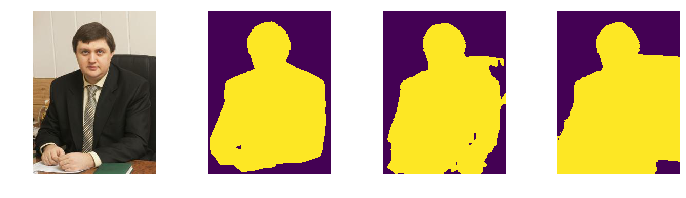

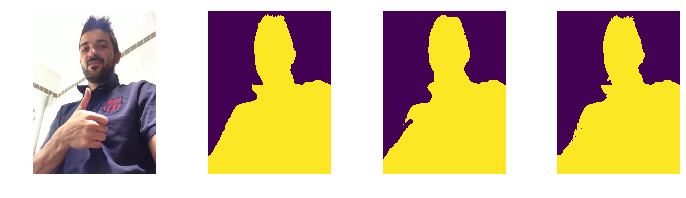

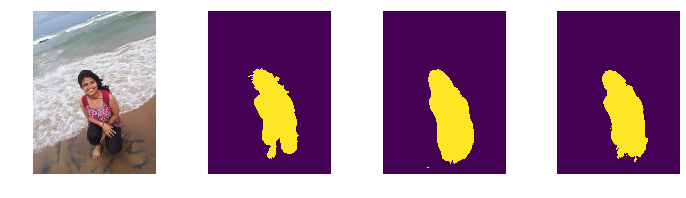

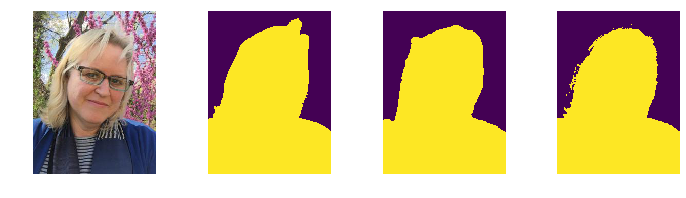

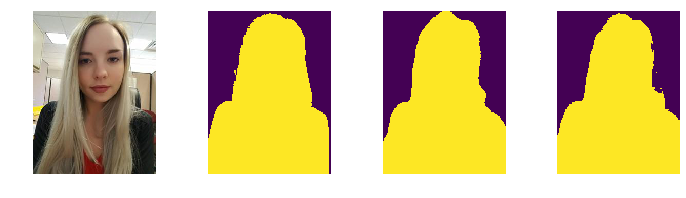

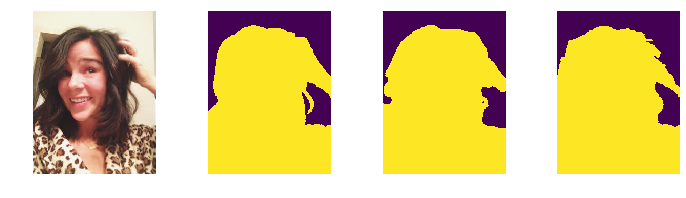

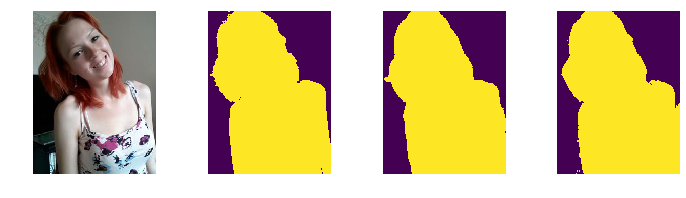

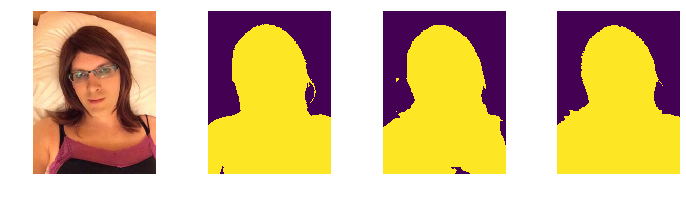

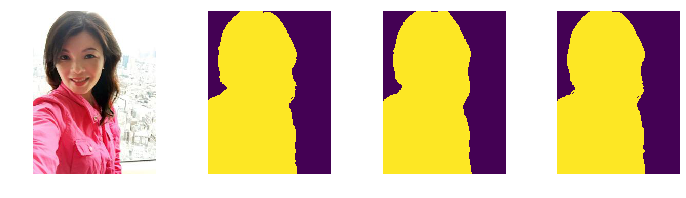

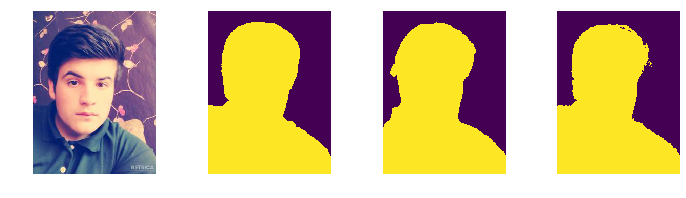

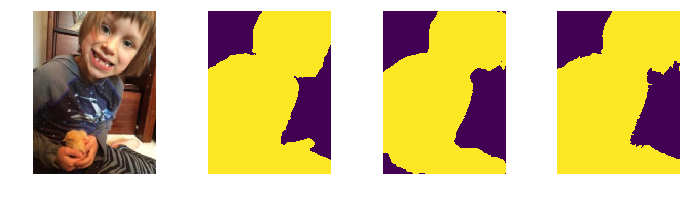

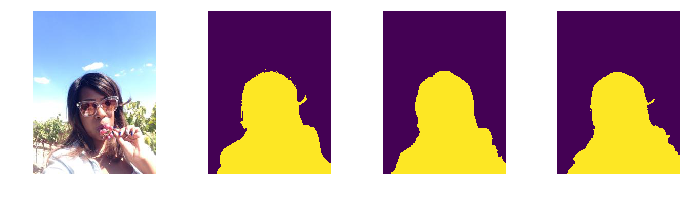

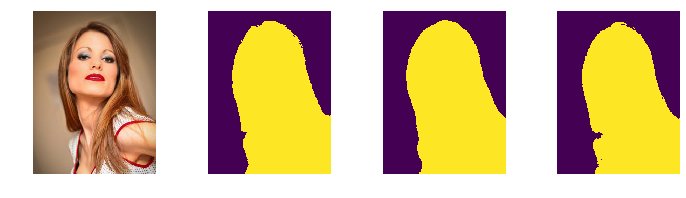

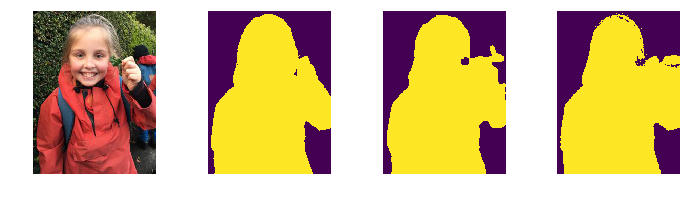

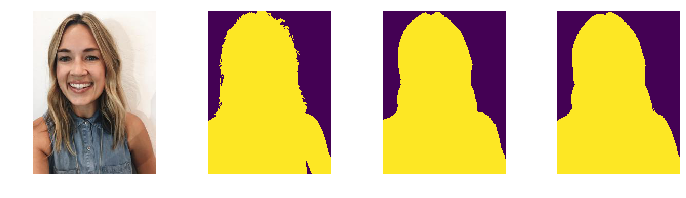

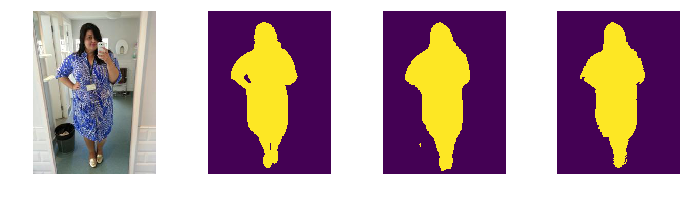

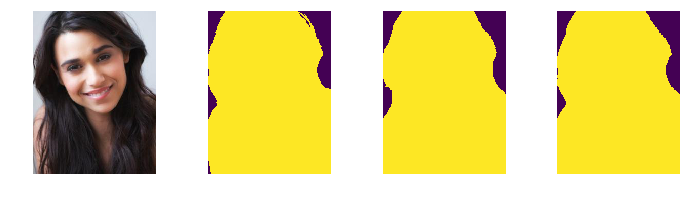

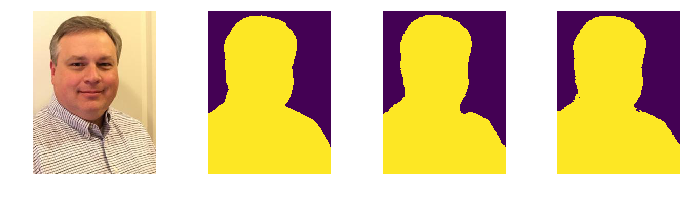

In [12]:
scores_crf = []
scores = []
for img_path, mask_path in zip(os.listdir(TEST), os.listdir(TEST_MSK)):
    img = plt.imread(os.path.join(TEST, img_path))
    img_ = cv2.resize(img, (224, 224))
    mask = plt.imread(os.path.join(TEST_MSK, mask_path))
    pred_crf = crf_model.get_mask(img_)
    pred_crf = cv2.resize(pred_crf.astype(np.uint8), mask.shape[::-1])
    pred = crf_model.get_mask(img_, no_crf=True)
    pred = cv2.resize(pred.astype(np.uint8), mask.shape[::-1])
    
    scores.append(metrics.dice(mask, pred))
    scores_crf.append(metrics.dice(mask, pred_crf))
    
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(142)
    plt.axis("off")
    plt.imshow(mask)
    plt.subplot(143)
    plt.axis("off")
    plt.imshow(pred)
    plt.subplot(144)
    plt.axis("off")
    plt.imshow(pred_crf)
    
print(np.mean(scores), np.mean(scores_crf))

Таким образом, получается, что на более сильной модели, хоть CRF и позволил убрать некоторые артефакты сегментации, но при этом также добавил особенности на краях. На более слабой модели CRF позволил немного поднять качество работы.

По итогам тестов из двух моделей выбрана `U-net+SE-ResNeXt50` в качестве финальной.

# Применение итоговых моделей

## Маски на валидации

In [13]:
# U-Net
model = torch.load("models/unet_seresnext50.pth")
crf_model = models.CRFModel(model, DEVICE)

In [16]:
data = pd.read_csv("data/pred_valid_template.csv", index_col="id")
data.head()

rle_mask
id                                                     
1315  9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1316  9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1317  9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1318  9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1319  9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...

In [21]:
for i in data.index:
    img = plt.imread(os.path.join(VAL, f"{i}.jpg"))
    img_ = cv2.resize(img, (224, 224))
    pred = crf_model.get_mask(img_, no_crf=True)
    pred = cv2.resize(pred.astype(np.uint8), mask.shape[::-1])
    
    data.loc[i] = encode_rle(pred)

In [23]:
data.to_csv("results/pred_masks.csv")

## Изображения на тесте

In [38]:
for path in os.listdir("data/sub/"):
    img = plt.imread("data/sub/" + path)
    img_ = cv2.resize(img, (224, 224))
    pred = crf_model.get_mask(img_, no_crf=True)
    pred = cv2.resize(pred.astype(np.uint8), (240, 320))
    
    plt.imsave("data/mask/" + path, pred, cmap="gray")

In [45]:
paths_to_imgs = sorted(glob("data/sub/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")